In [17]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, precision_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from model_utils import rolling_test, optimize_threshold
from preprocessing import feature_engineering, analyze_features
plt.style.use("ggplot")

In [18]:
df = pd.read_csv('../data/df.csv', index_col='date', parse_dates=True)

In [19]:
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

In [20]:
features_df = feature_engineering(df)
features_df["target"] = df["target"]
features_df.dropna(inplace=True)

In [21]:
X = features_df.drop(columns="target")
y = features_df["target"]

The features used in this model were selected based on common technical indicators and transformations known to be relevant in financial time series prediction. The `feature_engineering` function includes indicators such as `Momentums`, `Trend indicators`, `Volume-related metrics`, `Volatility measures`, `returns`, etc.
While no formal feature selection techniques like `Recursive Feature Elimination (RFE)` or `SHAP` were applied at this stage, the choice was driven by domain knowledge and initial exploratory data analysis (see `01_eda.ipynb`), however, this features were chosen for a later mlp (`03_modeling.ipynb`).

In [22]:
# Total samples ~500, validation size 100
#Chosen to preserve sufficient training history (~400 points).
#Ensures the validation set mimics the most recent market behavior.
val_size = 100
X_train, X_test = X.iloc[:-val_size], X.iloc[-val_size:]
y_train, y_test = y.iloc[:-val_size], y.iloc[-val_size:]
# This split mantains the temporal order of the data, preventing data leakage.

In [23]:
pw = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = pw.fit_transform(X_train)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = qt.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)

c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (384). n_quantiles is set to n_samples.
  warnings.warn(


In [24]:
# Skewness and kurtosis analysis
print('Skewness:\n', X_scaled.skew().sort_values(ascending=False))
print('\nKurtosis:\n', X_scaled.kurtosis().sort_values(ascending=False))

X_scaled.skew().sort_values(ascending=False).to_csv('../reports/skewness.csv')
X_scaled.kurtosis().sort_values(ascending=False).to_csv('../reports/kurtosis.csv')

Skewness:
 high_low                 1.703617e-11
close_pct_change         1.703366e-11
close_pct_change_lag1    1.703356e-11
low_close                1.703337e-11
momentum_lag1            1.703223e-11
candle_body_ratio        1.703207e-11
sma_ratio_10_20_lag1     1.703207e-11
cum_return_7_lag1        1.703121e-11
log_return_5             1.703121e-11
dtype: float64

Kurtosis:
 low_close                2.303063
candle_body_ratio        2.303063
close_pct_change         2.303063
momentum_lag1            2.303063
close_pct_change_lag1    2.303063
cum_return_7_lag1        2.303063
high_low                 2.303063
sma_ratio_10_20_lag1     2.303063
log_return_5             2.303063
dtype: float64


In [25]:
# Mutual Information
mi = mutual_info_classif(X_scaled, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_scaled.columns).sort_values(ascending=False)
print("\n Mutual Information:\n", mi_series)

mi_series.to_csv('../reports/mi_scores.csv')


 Mutual Information:
 candle_body_ratio        0.037250
high_low                 0.036431
cum_return_7_lag1        0.033438
close_pct_change         0.025517
sma_ratio_10_20_lag1     0.021576
close_pct_change_lag1    0.021143
low_close                0.003031
log_return_5             0.000000
momentum_lag1            0.000000
dtype: float64


In [26]:
# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print("\n>> VIF:\n", vif_data.sort_values("VIF", ascending=False))

vif_data.to_csv('../reports/vif_scores.csv', index=False)


>> VIF:
                  feature       VIF
6           log_return_5  5.880139
8          momentum_lag1  4.353153
3              low_close  3.823645
0       close_pct_change  3.805063
2      cum_return_7_lag1  2.676801
4               high_low  2.175555
1  close_pct_change_lag1  1.514269
7      candle_body_ratio  1.255667
5   sma_ratio_10_20_lag1  1.200398


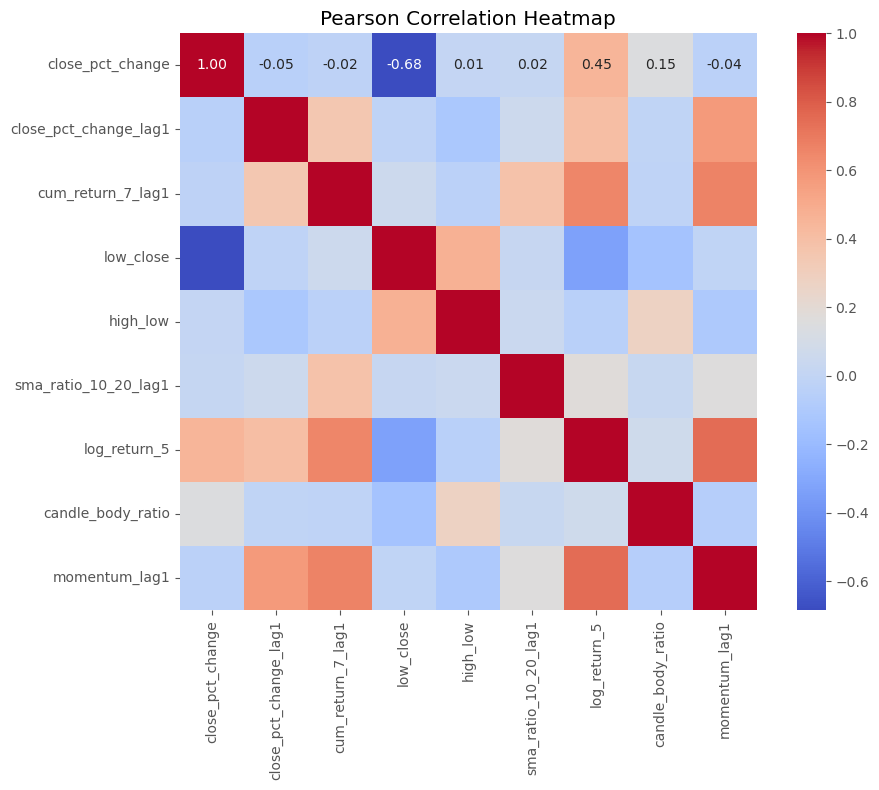

In [27]:
# Pearson correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation Heatmap")
plt.tight_layout()
plt.savefig("../reports/figures/Pearson_correlation_heatmap.png")
plt.show()
plt.close()

In [28]:
pipeline = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ("scaler", QuantileTransformer(output_distribution='normal', random_state=42)),
    ("model", HistGradientBoostingClassifier(random_state=42))
])

param_grid = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_iter': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_leaf': [10, 20]
}

In [29]:
tscv = TimeSeriesSplit(n_splits=4)

scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score)
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1', #F1 (primary, due to class imbalance)
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

In [30]:
grid.fit(X_train, y_train)

print("Best hiperparams:")
print(grid.best_params_)

print("\nBest F1 in validation:")
print(grid.best_score_)

best_pipeline = grid.best_estimator_

Fitting 4 folds for each of 54 candidates, totalling 216 fits


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (384). n_quantiles is set to n_samples.
  warnings.warn(


Best hiperparams:
{'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__max_iter': 200, 'model__min_samples_leaf': 20}

Best F1 in validation:
0.5650062656641605


In [31]:
# To simulate real-world deployment and robustness over time, a rolling window test is implemented.

"""
min_train_size=250: Ensures the model sees at least 250 samples before any test, giving it enough historical context.
test_window=50: Each test step simulates a 50-day forward prediction window.
step=25: Partial overlap allows higher resolution without retraining at every single step.
"""
results = rolling_test(best_pipeline, X, y, test_window=50, step=25, min_train_size=250, verbose=True)

c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (275). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (325). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of 

>>> Rolling Test (threshold 0.5):
Mean Accuracy: 0.5275
Mean F1 Score: 0.5245
Mean ROC AUC Score: 0.5629


In [32]:
X.to_csv('../data/X.csv')
y.to_csv('../data/y.csv')